# **GROUP 103 Final Project**

For our Final Project we (Jackson Wood, Frank Li, Ethan Seto) decided to run sentiment analysis on infamous reddit page *WallStreetBets*, which has recently been in the spotlight after Gamestop stock saw huge amounts of manipulation following a move by their community to pump the stock.

We intend to study the effect Reddit users in the Wall Street Bets subreddit have on the stock price of GME by studying all mentions of ‘GME’ and ‘GameStop’ in the subreddit. 

The ultimate objective is to create a model that will predict the movement of GME's stock in the future using Reddit metrics. More specifically, we want the ML to be able to predict if the price of the stock will increase or decrease on each day based on the subreddit data.

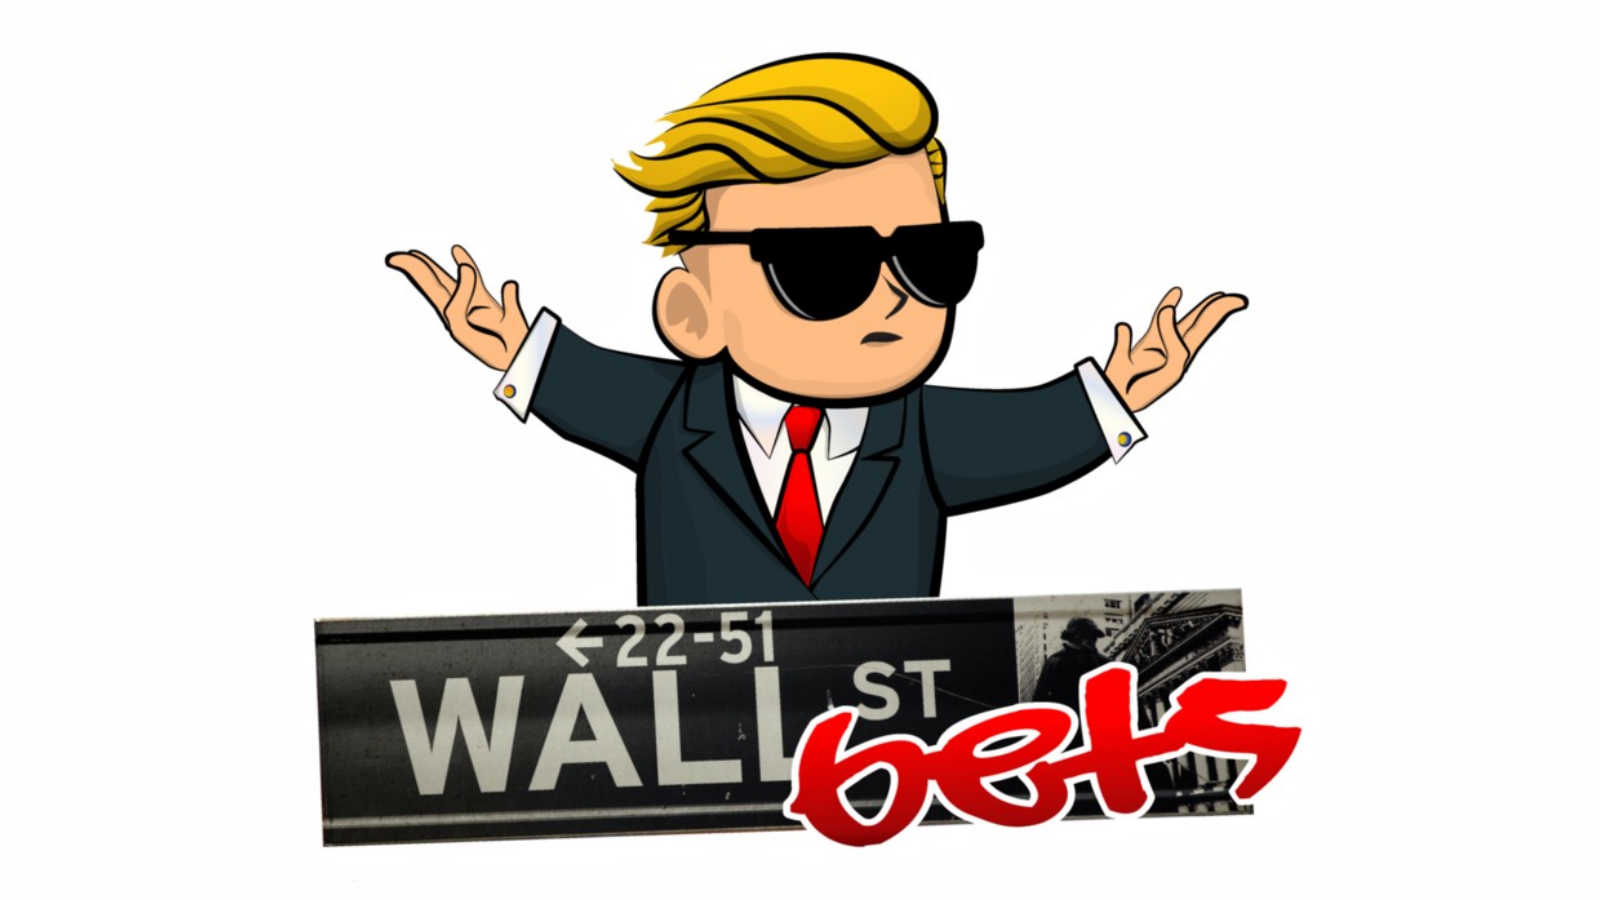

Retail investors have been a huge topic of discussion in the past year, with GME surging after a Reddit group called WallStreetBets began a campaign against Institutional Investors. 

Since then, GME stock has increased by almost 10x. We want to analyze the effect that this Reddit group had by measuring activity on the subreddit and comparing it to the stock price on each day. 

We think it will be interesting to see what kind of effect posts, upvotes, and comments made about GME have on the price of the stock, to see if we can predict what might happen in
the future. 

In addition, this type of analysis is interesting because it can be similarly performed on other companies that might be affected by any form of mass media outside of Reddit, with AMC as a notable example.


#Part 0: Import necessary libraries and load data

Here we import some relatively standard python libraries such as pandas for data analysis and matplotlib/worldcloud for visualizations. 

We also use yfinance as our datasource for the stock data, which enables us to easily pull daily stock price data on Gamestop.

In [540]:
import pandas as pd
import numpy as np
import seaborn as sns
from string import ascii_letters
import matplotlib.pyplot as plt
import datetime as dt
import requests
from lxml import html
from wordcloud import WordCloud

In [541]:
%%capture
!pip install yfinance
! pip install yfinance --user

In [542]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev

#Part 1: Load & Process Datasets

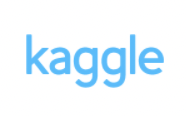

In order to obtain WSB subreddit data we need to use Kaggle's API. Kaggle is a platform where anyone can post datasets for others to use. We found a dataset containing WallstreetBets subreddit data for 2021. 

For the subreddit data we used two separate datasources. We found that one of the datasets only had data past February 2021, while the other had all the way back to 2012. We joined these two tables in order to create a comprehensive dataset for our Analysis.

Here are links to the datasets:

https://www.kaggle.com/gpreda/reddit-wallstreetsbets-posts

https://www.kaggle.com/unanimad/reddit-rwallstreetbets




In [543]:
! pip uninstall kaggle #get new kaggle
! pip install kaggle

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Would remove:
    /usr/local/bin/kaggle
    /usr/local/lib/python3.7/dist-packages/kaggle-1.5.12.dist-info/*
    /usr/local/lib/python3.7/dist-packages/kaggle/*
Proceed (y/n)? y
  Successfully uninstalled kaggle-1.5.12
  Using cached kaggle-1.5.12-py3-none-any.whl


## Getting 2012 - early 2021 WSB Data

In [544]:
from google.colab import files
files.upload() #upload API file
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d unanimad/reddit-rwallstreetbets
! unzip '/content/reddit-rwallstreetbets.zip'

Saving kaggle.json to kaggle (4).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
reddit-rwallstreetbets.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/reddit-rwallstreetbets.zip
replace r_wallstreetbets_posts.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [545]:
pre2021_posts = pd.read_csv('r_wallstreetbets_posts.csv')
pre2021_posts

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


id  ... over_18
0        ll0n5k  ...   False
1        ll0n4p  ...   False
2        ll0my2  ...   False
3        ll0mxr  ...   False
4        ll0mx4  ...   False
...         ...  ...     ...
1118858   shtex  ...   False
1118859   se66f  ...   False
1118860   sd5ai  ...   False
1118861   s6r57  ...   False
1118862   s4jw1  ...   False

[1118863 rows x 12 columns]

In [546]:
pre2021_posts.columns

Index(['id', 'title', 'score', 'author', 'author_flair_text', 'removed_by',
       'total_awards_received', 'awarders', 'created_utc', 'full_link',
       'num_comments', 'over_18'],
      dtype='object')

The first step in the process was to convert from utc time to datetime. We do that below. 

In addition, we removed all columns that were irrelevent to our analysis 

In [547]:
pre2021_posts['created_utc'] = pd.to_datetime(pre2021_posts['created_utc'], unit = 's')
pre2021_posts = pre2021_posts.sort_values(by='created_utc')
pre2021_posts = pre2021_posts.rename(columns={"created_utc": "Date"})
pre2021_posts = pre2021_posts[['title', 'score', 'Date', 'num_comments']]
pre2021_posts.reset_index(drop=True, inplace=True)

Lets take a quick look at what we have so far!



In [548]:
pre2021_posts

title  ...  num_comments
0               Earnings season is here.  Place your bets.  ...            22
1               GOOG - beat estimates, price barely rises.  ...             0
2        My poorly timed opening position for AAPL earn...  ...            21
3        Anyone betting on VVUS and their potential app...  ...             0
4        EBAY posts higher 1Q net income and revenue, s...  ...             4
...                                                    ...  ...           ...
1118858                                         Buy TRXC 🚀  ...             2
1118859                                          Airlines?  ...             2
1118860       XRT is being used as a laundry short machine  ...             2
1118861  Need explanations on Level 2 data for GME, why...  ...             2
1118862                          Whats going on with PLTR?  ...             2

[1118863 rows x 4 columns]

## Getting 2021 WSB Data

In [549]:
! kaggle datasets download gpreda/reddit-wallstreetsbets-posts
! unzip '/content/reddit-wallstreetsbets-posts.zip'
posts_2021 = pd.read_csv('/content/reddit_wsb.csv')
posts_2021.columns

reddit-wallstreetsbets-posts.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/reddit-wallstreetsbets-posts.zip
replace reddit_wsb.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


Index(['title', 'score', 'id', 'url', 'comms_num', 'created', 'body',
       'timestamp'],
      dtype='object')

In [550]:
posts_2021 = posts_2021[['title', 'score', 'timestamp', 'comms_num']]
posts_2021

title  ...  comms_num
0      It's not about the money, it's about sending a...  ...          6
1      Math Professor Scott Steiner says the numbers ...  ...         23
2                                        Exit the system  ...         47
3      NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...  ...         74
4      Not to distract from GME, just thought our AMC...  ...        156
...                                                  ...  ...        ...
53182    What I Learned Investigating SAVA FUD Spreaders  ...         87
53183  Daily Popular Tickers Thread for August 02, 20...  ...       1070
53184       Hitler reacts to the market being irrational  ...        372
53185        Daily Discussion Thread for August 02, 2021  ...      11688
53186  Fraternal Association of Gambling Gentlemen an...  ...        810

[53187 rows x 4 columns]

In [551]:
posts_2021 = posts_2021.rename(columns={"timestamp": "Date", 'comms_num': 'num_comments'})

posts_2021['Date'] = pd.to_datetime(posts_2021['Date']).dt.date
posts_2021.drop_duplicates(['title'], inplace=True)

pre2021_posts['Date'] = pd.to_datetime(pre2021_posts['Date']).dt.date
pre2021_posts.drop_duplicates(['title'], inplace=True)

In [552]:
posts_2021.size

208196

In [553]:
pre2021_posts.size

4063804

In [554]:
posts_2021.columns

Index(['title', 'score', 'Date', 'num_comments'], dtype='object')

In [555]:
pre2021_posts.columns

Index(['title', 'score', 'Date', 'num_comments'], dtype='object')

In [556]:
pre2021_posts.dropna(subset=['title'], inplace=True)
pre2021_posts.size

4063800

In [557]:
posts_2021.dropna(subset=['title'], inplace=True)
posts_2021.size

208196

In [558]:
gme_pre2021 = pre2021_posts[(pre2021_posts['title'].str.contains('gme|gamestop|game stop'))]
gme_2021 = posts_2021[(posts_2021['title'].str.contains('gme|gamestop|game stop'))]

The same can be done for other specific ticker related posts. AMC is another one to consider for future research.

In [559]:
amc_pre2021 = pre2021_posts[(pre2021_posts['title'].str.contains('amc'))]
amc_2021 = posts_2021[(posts_2021['title'].str.contains('amc'))]

In [560]:
gme_pre2021.size

22200

In [561]:
gme_2021.size

1408

In [562]:
amc_posts = pd.concat([amc_pre2021, amc_2021], axis=0)

## Combine datasets to one dataframe

In [563]:
gme_posts = pd.concat([gme_pre2021, posts_2021], axis=0)
gme_posts

title  ...  num_comments
200             Options v. Pennies: Day 3 - Judgment Day  ...            18
3423   Get in on some gamestop on this dip? What are ...  ...             7
4717   $GME (gamestop) up 7% premarket based off good...  ...             8
19458  LB: is the L brands model broke? Company decid...  ...             2
21271                        gamestop earning play today  ...            37
...                                                  ...  ...           ...
53182    What I Learned Investigating SAVA FUD Spreaders  ...            87
53183  Daily Popular Tickers Thread for August 02, 20...  ...          1070
53184       Hitler reacts to the market being irrational  ...           372
53185        Daily Discussion Thread for August 02, 2021  ...         11688
53186  Fraternal Association of Gambling Gentlemen an...  ...           810

[57599 rows x 4 columns]

## Retrieve YFinance GME Stock Data

Next we import yfinance and load our stock data for Gamestop (GME)



In [564]:
import yfinance as yf

gamestop = yf.Ticker("GME")
gme_df = gamestop.history(start="2012-01-01",  end="2021-12-10")
gme_df = gme_df.reset_index()

GME stock since 2021:

In [565]:
gme_df_2021 = gamestop.history(start="2021-01-01",  end="2021-12-10")
gme_df_2021 = gme_df_2021.reset_index()
gme_df_2021

Date        Open        High  ...    Volume  Dividends  Stock Splits
0   2021-01-04   19.000000   19.100000  ...  10022500          0             0
1   2021-01-05   17.350000   18.080000  ...   4961500          0             0
2   2021-01-06   17.340000   18.980000  ...   6056200          0             0
3   2021-01-07   18.469999   19.450001  ...   6129300          0             0
4   2021-01-08   18.180000   18.299999  ...   6482000          0             0
..         ...         ...         ...  ...       ...        ...           ...
232 2021-12-03  181.000000  183.929993  ...   4092900          0             0
233 2021-12-06  166.000000  173.339996  ...   2228600          0             0
234 2021-12-07  175.179993  181.979996  ...   1972400          0             0
235 2021-12-08  176.600006  180.250000  ...   2611200          0             0
236 2021-12-09  167.000000  172.690002  ...   5084300          0             0

[237 rows x 8 columns]

#Part 2: Visualize & Standardize GME Stock Data

Plot of GME stock in 2021:

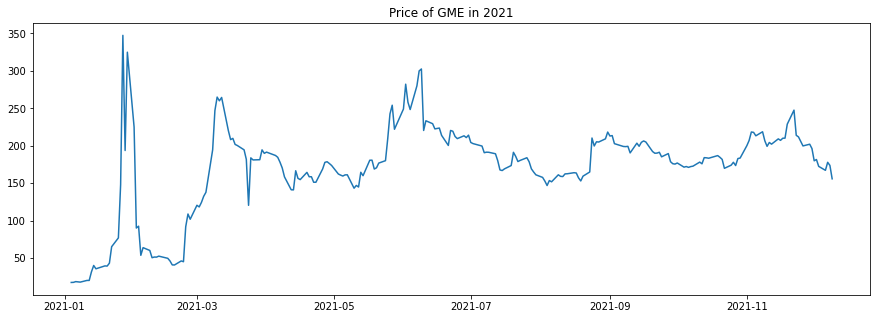

In [566]:
plt.figure(figsize=(15,5))
plt.plot(gme_df_2021['Date'], gme_df_2021['Close'])
plt.title('Price of GME in 2021')
plt.show()

As we can see above, the price of GME spiked in the end of January, largely due to activity on the WallstreetBets subreddit. We want to look at the relationship between the two datasets

## Normalize GME stock

Now we will normalize GME stock with respect to SPY in order to eliminate any change in stock price that was due to market movement.

In [567]:
spy = yf.Ticker("SPY")
spy_df = spy.history(start="2012-01-01",  end="2021-12-10")
spy_df = spy_df.reset_index()
spy_df

Date        Open        High  ...     Volume  Dividends  Stock Splits
0    2012-01-03  105.862144  106.375879  ...  193697900        0.0             0
1    2012-01-04  105.398146  105.903593  ...  127186500        0.0             0
2    2012-01-05  105.240710  106.251598  ...  173895000        0.0             0
3    2012-01-06  106.226730  106.243305  ...  148050000        0.0             0
4    2012-01-09  106.061008  106.210150  ...   99530200        0.0             0
...         ...         ...         ...  ...        ...        ...           ...
2497 2021-12-03  459.170013  460.299988  ...  137167700        0.0             0
2498 2021-12-06  456.130005  460.790009  ...   98977500        0.0             0
2499 2021-12-07  464.410004  468.880005  ...   95484700        0.0             0
2500 2021-12-08  468.700012  470.000000  ...   72238800        0.0             0
2501 2021-12-09  468.149994  469.630005  ...   61272600        0.0             0

[2502 rows x 8 columns]

In [568]:
gme_df['Normalized'] = gme_df['Close'] / spy_df['Close']

## Visualize GME Stock Data

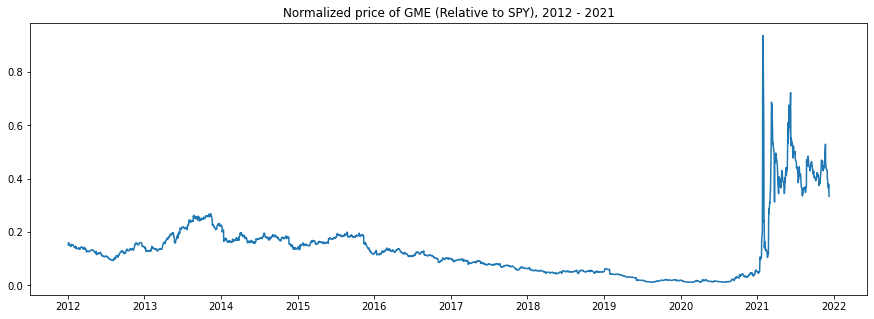

In [569]:
plt.figure(figsize=(15,5))
plt.plot(gme_df['Date'], gme_df['Normalized'])
plt.title('Normalized price of GME (Relative to SPY), 2012 - 2021')
plt.show()

As we can see in this visualization, GME drastically outperformed SPY during their hype cycle.



Check out dataframes' info:

In [570]:
gme_posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57599 entries, 200 to 53186
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         57599 non-null  object
 1   score         57599 non-null  int64 
 2   Date          57599 non-null  object
 3   num_comments  57599 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [571]:
gme_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2502 entries, 0 to 2501
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2502 non-null   datetime64[ns]
 1   Open          2502 non-null   float64       
 2   High          2502 non-null   float64       
 3   Low           2502 non-null   float64       
 4   Close         2502 non-null   float64       
 5   Volume        2502 non-null   int64         
 6   Dividends     2502 non-null   float64       
 7   Stock Splits  2502 non-null   int64         
 8   Normalized    2502 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 176.0 KB


Do some quick cleaning by dropping unnecessary columns and converting date types!

In [572]:
gme_df = gme_df.drop(columns=['Dividends', 'Stock Splits'])
gme_df['Date'] = pd.to_datetime(gme_df['Date']).dt.date
gme_df

Date        Open        High  ...       Close   Volume  Normalized
0     2012-01-03   16.448724   16.556452  ...   16.017813  2563200    0.151617
1     2012-01-04   15.990877   16.280397  ...   16.246731  2079400    0.153543
2     2012-01-05   16.152469   17.021027  ...   17.007561  3694000    0.160306
3     2012-01-06   16.973895   16.987361  ...   16.744974  3778400    0.158239
4     2012-01-09   16.603581   16.630513  ...   16.152470  6956000    0.152270
...          ...         ...         ...  ...         ...      ...         ...
2497  2021-12-03  181.000000  183.929993  ...  172.389999  4092900    0.380199
2498  2021-12-06  166.000000  173.339996  ...  167.119995  2228600    0.364262
2499  2021-12-07  175.179993  181.979996  ...  177.809998  1972400    0.379709
2500  2021-12-08  176.600006  180.250000  ...  173.649994  2611200    0.369846
2501  2021-12-09  167.000000  172.690002  ...  155.759995  5084300    0.333998

[2502 rows x 7 columns]

#Part 3: Summary Stats

Next we calculate average_score (upvotes), average_num_comms, median_score and median_num_comms among all WSB posts

This is purely to summarize the data we have so far

In [573]:
average_score = gme_posts.score.mean()
median_score = gme_posts.score.median()
average_num_comms = gme_posts.num_comments.mean()
median_num_comms = gme_posts.num_comments.median()

In [574]:
print("Average Score: ", average_score)
print("Median Score: ", median_score)
print("Average # of Comments: ", average_num_comms)
print("Median # of Comments: ", median_num_comms)

Average Score:  1256.0285074393653
Median Score:  25.0
Average # of Comments:  242.40406951509576
Median # of Comments:  14.0


By looking at both the score and comments, notice that the distribution is bottom-skewed, with a few very popular posts driving the average score and average number of comments far above the respective medians.

#Part 4: Initial Cleaning and EDA (Adding Columns) 

For this section we start the process of cleaning the data. 

This involves 


1.   converting emojis to text
2.   cleaning 'titles' (e.g., removing whitespaces, lowercasing, etc.)
3.   drop duplicate titles
4.   one hot encoding titles with certain words
5.   possible consideration - adding profanity checker




In [575]:
gme_posts['title_length'] = gme_posts['title'].str.split().str.len()

Convert Emojis to text for sentiment analysis using the emot module, as well as other necessary imports for tokenizing/cleaning.

In [576]:
!pip install emot
! pip install unidecode
! pip install autocorrect
import emot
import re
import pickle
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
import unidecode
import pandas as pd
import re 
import time
import string
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from autocorrect import Speller
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import string
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Emoji Conversion

We want to be able to capture some of the sentiment emojis convey. As a result, we converted emojis to their english equivalent meaning.

In [577]:
def convert_emojis(text):
  for emot in UNICODE_EMOJI:
    text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
  return text
gme_posts['title_converted_emojis'] = gme_posts['title'].apply(convert_emojis)

## Clean Post Titles

Here, we define many cleaning functions:


*   Remove tabs, newlines, and '.com's, links ('http'), whitespaces, accents, repeated characters
*   Lowercase all characters
*   Expand common contractions
*   Tokenize
- Remove stopwords






In [578]:
# remove tabs and newlines while combining ".com"s
def tabs_and_newlines(text):
  updated_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t', ' ').replace('\\', ' ').replace('. com', '.com')
  return updated_text

# remove links attached to the title
def links(text):
  https = re.sub(r"http\S+", "", text)

  com = re.sub(r"\ [A-Za-z]*\.com", " ", https)
  return com

# removes whitespaces in addition to separating common end punctuation from their attached words
def whitespaces(text):
  x = re.compile(r'\s+')
  no_whitespace = re.sub(x, ' ', text)

  updated_text = no_whitespace.replace('?', ' ? ').replace(')', ' ) ').replace('!', ' ! ').replace('.', ' . ')
  return updated_text

# removes characters with accents
def accented_special_characters(text):
  updated_text = unidecode.unidecode(text)
  return updated_text

# lowercases all text
def lowercase(text):
  updated_text = text.lower()
  return updated_text

# remove repeated characters
def repeated_characters(text):
  alpha_patt = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
  new_text = alpha_patt.sub(r"\1\1", text)

  punct_patt = re.compile(r"([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}")
  limit_punct = punct_patt.sub(r'\1', new_text)

  updated_text = re.sub(' {2,}', ' ', limit_punct) # spaces
  return updated_text

In [579]:
# list of common contractions taken from similar NLP cleaning pipelines in addition to our own that we feel were "reddit-common"
contractions = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
    "lol": "laugh out loud",
    "lmao": "laugh my ass off",
    "tl;dr": "too long; didn't read",
    "fud": "fear uncertainty doubt",
    "hodl": "hold on for dear life"
}

def contractions_remove(text, contraction_mapping =  contractions):
    list_of_tokens = text.split(' ')

    for word in list_of_tokens: 
         if word in contractions: 
                list_of_tokens = [item.replace(word, contractions[word]) for item in list_of_tokens]
              
    # Converting list of tokens to String.
    string = ' '.join(str(x) for x in list_of_tokens) 
    return string

In [580]:
def special_chars(text):
  updated_text = re.sub(r"[^a-zA-Z0-9:$-,%.?!]+", ' ', text)
  return updated_text

def tokenize(text):
  tokenizer = RegexpTokenizer(r'\w+')
  update = tokenizer.tokenize(text)
  return update

def stopwords_remove(text):
  stop = stopwords.words('english')

  string = ' '.join([x for x in text if x not in (stop)])
  return string

# no lemmatization or stemming for fear that it will change the meanings of many words especially since reddit language will be more casual and involve more abbreviations

Note that we did not apply **lemmatization** or **stemming**, even though they are frequently used for NLP cleaning, because we feared that doing so would change the meanings of many words. This is especially given the fact that reddit language is not the most formal and will involve many abbreviations and shorthands.

We then apply all these functions to our data set:

In [581]:
gme_posts.drop_duplicates(['title'], inplace=True)
clean_gme = gme_posts.copy()
clean_gme['title_converted_emojis'] = clean_gme['title_converted_emojis'].apply(lambda x : tabs_and_newlines(x)).apply(lambda x : links(x)).apply(lambda x : whitespaces(x)).apply(lambda x : accented_special_characters(x)).apply(lambda x : lowercase(x)).apply(lambda x : repeated_characters(x)).apply(lambda x : contractions_remove(x)).apply(lambda x : special_chars(x)).apply(lambda x : tokenize(x)).apply(lambda x : stopwords_remove(x))
clean_gme

title  ...                             title_converted_emojis
200             Options v. Pennies: Day 3 - Judgment Day  ...               options v pennies day 3 judgment day
3423   Get in on some gamestop on this dip? What are ...  ...                      get gamestop dip thoughts gme
4717   $GME (gamestop) up 7% premarket based off good...  ...       gme gamestop 7 premarket based good earnings
19458  LB: is the L brands model broke? Company decid...  ...  lb l brands model broke company decided shutte...
21271                        gamestop earning play today  ...                        gamestop earning play today
...                                                  ...  ...                                                ...
53182    What I Learned Investigating SAVA FUD Spreaders  ...  learned investigating sava fear uncertainty do...
53183  Daily Popular Tickers Thread for August 02, 20...  ...  daily popular tickers thread august 02 2021 ba...
53184       Hitler reacts to the market being irrational  ...                    hitler reacts market irrational
53185        Daily Discussion Thread for August 02, 2021  ...             daily discussion thread august 02 2021
53186  Fraternal Association of Gambling Gentlemen an...  ...  fraternal association gambling gentlemen yacht...

[57428 rows x 6 columns]

## Recording Word-specific Titles

We now want a WordCloud of the most common words in our clean_gme 'title_converted_emojis' column. This column contains the original title after the cleaning as well as any emoji-translated words. We first create a single string seperating titles by a space, and then generate the plot.

In [582]:
title_gme_text = " ".join(x for x in clean_gme['title_converted_emojis'].astype(str))
title_gme_text

'options v pennies day 3 judgment day get gamestop dip thoughts gme gme gamestop 7 premarket based good earnings lb l brands model broke company decided shutter swim wear segment reported first miss stock 30 ytd anyone insights double gtfo gamestop earning play today virtual augmented reality market reach 162 billion 2020 anyone playing gme ahead earnings augmented reality future whos long gme hope guys watching gme mean google report big loss fiber segment started learning swing trading last 4 months augment dayjob buy gme toys r us literally shittiest retailer toys segment 20 years business media reaction go bankrupt thanks sub lost right credibility decent human right fair judgment planet fitness thread judgment zone augmentation interest rate 4 15pm today red coming augmentation interest rate today 4 15pm red coming something wrong judgment day coming guys think shorting gamestop week amzn dd tasty new source ad segment revenue thank fatties need judgment free zone instead normal g

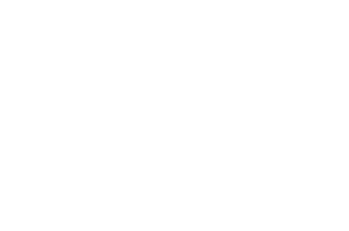

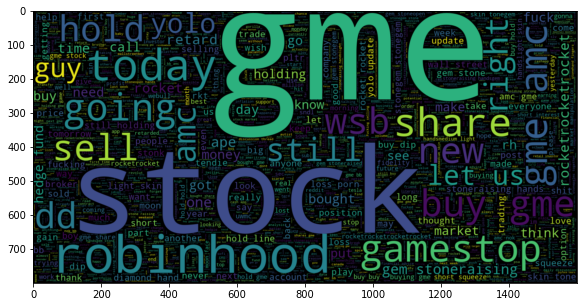

In [583]:
wordcloud = WordCloud(min_font_size=3, max_words=3000, width=1600, height=800).generate(title_gme_text)
plt.axis("off")
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

However, notice that many of the high frequency words are self-explanatory (e.g., gme). Let's filter out high frequency words that are not worth recording whether a title has them or not:

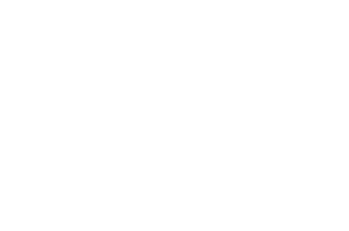

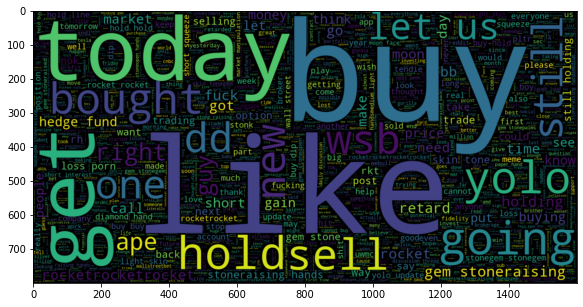

In [584]:
stopwords = ['gme', 'stock', 'gamestop', 'stocks', 'amc', 'robinhood', 'game', 'share', 'shares']
wordcloud = WordCloud(stopwords=stopwords, min_font_size=3, max_words=3000, width=1600, height=800).generate(title_gme_text)
plt.axis("off")
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

Note there are several prominent words and phrases that are very characteristic of the kinda of attitude that makes WSB both enticing and polarizing. For example, words like "rocket" and "gem", two frequently used emojis in the titles of WSB posts.

Next, in our knowledge of the WallStreetBets subreddits, there are certain "catchphrases" or "keywords" very distinctive to the subreddit; these words also pack more meaning than our sentiment analysis might pick up.

Words we consider are = 1 if title contains that word, 0 otherwise
*   like
*   buy
*   bought
*   sell
*   hold
*   new
*   rocket
*   moon
*   get
*   buying
*   gem
*   right

We hot-encode this: adding columns with a 1 if the title contains that word, and a 0 otherwise.

In [585]:
temp = clean_gme.copy()

def count(col_val, word):
  if col_val.find(word) != -1:
    return 1
  else:
    return 0

temp['like_title'] = temp['title_converted_emojis'].apply(lambda i : count(i, 'like'))
temp['buy_title'] = temp['title_converted_emojis'].apply(lambda i : count(i, 'buy'))
temp['bought_title'] = temp['title_converted_emojis'].apply(lambda i : count(i, 'bought'))
temp['sell_title'] = temp['title_converted_emojis'].apply(lambda i : count(i, 'sell'))
temp['hold_title'] = temp['title_converted_emojis'].apply(lambda i : count(i, 'hold'))
temp['new_title'] = temp['title_converted_emojis'].apply(lambda i : count(i, 'new'))
temp['rocket_title'] = temp['title_converted_emojis'].apply(lambda i : count(i, 'rocket'))
temp['moon_title'] = temp['title_converted_emojis'].apply(lambda i : count(i, 'moon'))
temp['get_title'] = temp['title_converted_emojis'].apply(lambda i : count(i, 'get'))
temp['buying_title'] = temp['title_converted_emojis'].apply(lambda i : count(i, 'buying'))
temp['gem_title'] = temp['title_converted_emojis'].apply(lambda i : count(i, 'gem'))
temp['right_title'] = temp['title_converted_emojis'].apply(lambda i : count(i, 'right'))

clean_gme = temp
clean_gme

title  ...  right_title
200             Options v. Pennies: Day 3 - Judgment Day  ...            0
3423   Get in on some gamestop on this dip? What are ...  ...            0
4717   $GME (gamestop) up 7% premarket based off good...  ...            0
19458  LB: is the L brands model broke? Company decid...  ...            0
21271                        gamestop earning play today  ...            0
...                                                  ...  ...          ...
53182    What I Learned Investigating SAVA FUD Spreaders  ...            0
53183  Daily Popular Tickers Thread for August 02, 20...  ...            0
53184       Hitler reacts to the market being irrational  ...            0
53185        Daily Discussion Thread for August 02, 2021  ...            0
53186  Fraternal Association of Gambling Gentlemen an...  ...            0

[57428 rows x 18 columns]

There is also a siginificant amount of profanity used on the WSB subreddit; as another feature for our ML model, we create a column for if the title contains profane words, using the profanity_filter module. However, given that this takes a long time to run, we save this for future study.


In [586]:
""" !pip install profanity_filter
from profanity_filter import ProfanityFilter """

' !pip install profanity_filter\nfrom profanity_filter import ProfanityFilter '

In [587]:
"""
pf = ProfanityFilter()
def profane(word):
  return pf.is_profane(word)
clean_gme['profane_title'] = clean_gme['title'].apply(lambda x : profane(x))
clean_gme['profane_title'] = clean_gme['profane_title'].astype(int)

"""

"\npf = ProfanityFilter()\ndef profane(word):\n  return pf.is_profane(word)\nclean_gme['profane_title'] = clean_gme['title'].apply(lambda x : profane(x))\nclean_gme['profane_title'] = clean_gme['profane_title'].astype(int)\n\n"

Now let's visualize overall activity on WSB over the years for GME, so we can better understand where most of the activity on WSB for GME is centralized for the past years.

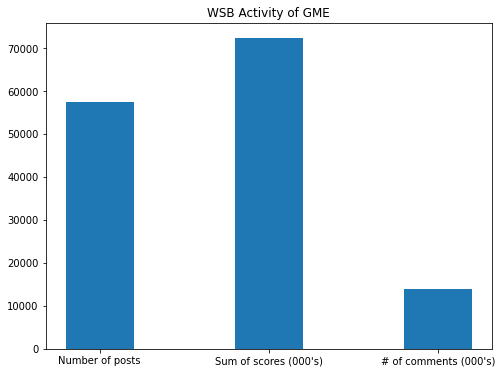

In [588]:
gme_bar_chart = (clean_gme.count()[0], clean_gme['score'].sum() / 10**3, clean_gme['num_comments'].sum() / 10**3)
amc_bar_chart = (amc_posts.count()[0], amc_posts['score'].sum() / 10**3, amc_posts['num_comments'].sum() / 10**3)
X = np.arange(3)

plt.figure(figsize=(8, 6))
plt.bar(X, gme_bar_chart, .4, label='GME')

plt.title('WSB Activity of GME')

plt.xticks(X, ('Number of posts', "Sum of scores (000's)", "# of comments (000's)"))
plt.show()

#Part 5: Perform Sentiment Analysis

We chose to use Afinn for our sentiment analysis.

Afinn takes in the title text (after converting emojis), and outputs a sentiment score between -5 and 5. We will be adding additional columns for words that Afinn possibly failed to take into account (mentioned above).

First we will install Afinn:

In [589]:
!pip install afinn
from afinn import Afinn

Apply Afinn to title_converted_emojis and add our new column 'title_sentiment' to clean_gme.



In [590]:
afinn = Afinn(language="en")
clean_gme['title_sentiment'] = clean_gme['title_converted_emojis'].apply(afinn.score)
clean_gme

title  ...  title_sentiment
200             Options v. Pennies: Day 3 - Judgment Day  ...              0.0
3423   Get in on some gamestop on this dip? What are ...  ...              0.0
4717   $GME (gamestop) up 7% premarket based off good...  ...              3.0
19458  LB: is the L brands model broke? Company decid...  ...             -3.0
21271                        gamestop earning play today  ...              0.0
...                                                  ...  ...              ...
53182    What I Learned Investigating SAVA FUD Spreaders  ...             -3.0
53183  Daily Popular Tickers Thread for August 02, 20...  ...              3.0
53184       Hitler reacts to the market being irrational  ...             -1.0
53185        Daily Discussion Thread for August 02, 2021  ...              0.0
53186  Fraternal Association of Gambling Gentlemen an...  ...              0.0

[57428 rows x 19 columns]

Sentiment analysis is one measure we wanted to take. By accounting for the general sentiment of certain titles, we can see if the stock prices would reflect that sentiment. Intuitively, this means that high number of positive posts would result in a higher chance of an "upward" trend in stock prices. Vice versa.

#Part 6: More EDA

## Create Summary Columns

Next we will add columns that give us the sum of metrics that we already have, grouped by date.

These new columns give us
- the sum of the score and number of comments of all posts
- the average title length of all posts
- the total counts of each of our "keywords" in each day.

In [591]:
clean_gme.columns

Index(['title', 'score', 'Date', 'num_comments', 'title_length',
       'title_converted_emojis', 'like_title', 'buy_title', 'bought_title',
       'sell_title', 'hold_title', 'new_title', 'rocket_title', 'moon_title',
       'get_title', 'buying_title', 'gem_title', 'right_title',
       'title_sentiment'],
      dtype='object')

In [592]:
columns = {'score': 'sum_score', 'num_comments': 'sum_comms_num', 'title_length': 'avg_title_length', 'like_title': 'like_count', 'buy_title': 'buy_count', 'bought_title': 'bought_count',\
           'sell_title': 'sell_count', 'hold_title': 'hold_count', 'new_title': 'new_count', 'rocket_title': 'rocket_count', 'moon_title': 'moon_count', 'get_title': 'get_count',\
           'buying_title': 'buying_count', 'gem_title': 'gem_count', 'right_title': 'right_count'}
summed_scores_and_comms = clean_gme.groupby(by=['Date']).agg({'score': 'sum', 'num_comments': 'sum', 'title_length': 'mean', 'like_title': 'sum', 'buy_title': 'sum', 'bought_title': 'sum',\
                                                                        'sell_title': 'sum', 'hold_title': 'sum', 'new_title': 'sum', 'rocket_title': 'sum', 'moon_title': 'sum', 'get_title': 'sum', \
                                                                        'buying_title': 'sum', 'gem_title': 'sum', 'right_title': 'sum'}).rename(columns=columns)
summed_scores_and_comms = summed_scores_and_comms.reset_index()
summed_scores_and_comms

Date  sum_score  sum_comms_num  ...  buying_count  gem_count  right_count
0    2012-06-01         21             18  ...             0          0            0
1    2014-11-21          2              7  ...             0          0            0
2    2015-05-29          1              8  ...             0          0            0
3    2016-05-05          9              2  ...             0          0            0
4    2016-05-26          6             37  ...             0          0            0
..          ...        ...            ...  ...           ...        ...          ...
310  2021-08-12      48431          36048  ...             2          2            1
311  2021-08-13      49205          44396  ...             0          1            0
312  2021-08-14      44579           5690  ...             0          0            2
313  2021-08-15      25423          13244  ...             0          0            0
314  2021-08-16        727            311  ...             1          0            0

[315 rows x 16 columns]

In [593]:
clean_gme = clean_gme.merge(summed_scores_and_comms, on='Date')
clean_gme

title  ...  right_count
0               Options v. Pennies: Day 3 - Judgment Day  ...            0
1      Get in on some gamestop on this dip? What are ...  ...            0
2      $GME (gamestop) up 7% premarket based off good...  ...            0
3      LB: is the L brands model broke? Company decid...  ...            0
4                            gamestop earning play today  ...            0
...                                                  ...  ...          ...
57423    What I Learned Investigating SAVA FUD Spreaders  ...            0
57424  Daily Popular Tickers Thread for August 02, 20...  ...            0
57425       Hitler reacts to the market being irrational  ...            0
57426        Daily Discussion Thread for August 02, 2021  ...            0
57427  Fraternal Association of Gambling Gentlemen an...  ...            0

[57428 rows x 34 columns]

We do the same thing using the count aggregate function to create a column that tells us the number of posts on any given day.

In [594]:
count_posts = clean_gme.groupby(by=['Date']).count()
count_posts = count_posts.reset_index()
count_posts = count_posts[['Date', 'title']]
count_posts = count_posts.rename(columns={"title": "num_posts"})
clean_gme = clean_gme.merge(count_posts, on='Date')
clean_gme

title  ...  num_posts
0               Options v. Pennies: Day 3 - Judgment Day  ...          1
1      Get in on some gamestop on this dip? What are ...  ...          1
2      $GME (gamestop) up 7% premarket based off good...  ...          1
3      LB: is the L brands model broke? Company decid...  ...          1
4                            gamestop earning play today  ...          1
...                                                  ...  ...        ...
57423    What I Learned Investigating SAVA FUD Spreaders  ...         25
57424  Daily Popular Tickers Thread for August 02, 20...  ...         25
57425       Hitler reacts to the market being irrational  ...         25
57426        Daily Discussion Thread for August 02, 2021  ...         25
57427  Fraternal Association of Gambling Gentlemen an...  ...         25

[57428 rows x 35 columns]

Creating a column for the max score and number of comments on a post for each day:

In [595]:
max_scores_and_comms = clean_gme.groupby(by=['Date']).max()
max_scores_and_comms = max_scores_and_comms.reset_index()
max_scores_and_comms = max_scores_and_comms[['Date', 'score', 'num_comments']]
max_scores_and_comms = max_scores_and_comms.rename(columns={"score": "max_score", "num_comments": "max_comms_num"})

clean_gme = clean_gme.merge(max_scores_and_comms, on='Date')
clean_gme

title  ...  max_comms_num
0               Options v. Pennies: Day 3 - Judgment Day  ...             18
1      Get in on some gamestop on this dip? What are ...  ...              7
2      $GME (gamestop) up 7% premarket based off good...  ...              8
3      LB: is the L brands model broke? Company decid...  ...              2
4                            gamestop earning play today  ...             37
...                                                  ...  ...            ...
57423    What I Learned Investigating SAVA FUD Spreaders  ...          11688
57424  Daily Popular Tickers Thread for August 02, 20...  ...          11688
57425       Hitler reacts to the market being irrational  ...          11688
57426        Daily Discussion Thread for August 02, 2021  ...          11688
57427  Fraternal Association of Gambling Gentlemen an...  ...          11688

[57428 rows x 37 columns]

## Create 'Relevancy' Columns

We then create columns that calulate various percentages for each individual post relative to the day it was posted. 

For example, percent_of_daily_max_score contains the score of the post / the max score for that day.

In [596]:
clean_gme['percent_of_daily_score'] = clean_gme.score / clean_gme.sum_score
clean_gme['percent_of_daily_comms'] = clean_gme.num_comments / clean_gme.sum_comms_num

clean_gme['percent_of_daily_max_score'] = clean_gme.score / clean_gme.sum_score
clean_gme['percent_of_daily_max_comms'] = clean_gme.num_comments / clean_gme.max_comms_num
clean_gme

title  ...  percent_of_daily_max_comms
0               Options v. Pennies: Day 3 - Judgment Day  ...                    1.000000
1      Get in on some gamestop on this dip? What are ...  ...                    1.000000
2      $GME (gamestop) up 7% premarket based off good...  ...                    1.000000
3      LB: is the L brands model broke? Company decid...  ...                    1.000000
4                            gamestop earning play today  ...                    1.000000
...                                                  ...  ...                         ...
57423    What I Learned Investigating SAVA FUD Spreaders  ...                    0.007444
57424  Daily Popular Tickers Thread for August 02, 20...  ...                    0.091547
57425       Hitler reacts to the market being irrational  ...                    0.031828
57426        Daily Discussion Thread for August 02, 2021  ...                    1.000000
57427  Fraternal Association of Gambling Gentlemen an...  ...                    0.069302

[57428 rows x 41 columns]

This is particularly important because not all posts attract the same activity and as a result potentially spur the same effect to GME stock. We want to make sure we account for that when we summarize certain features like sentiment analysis.

## Create Stock Trend Column

In the following cell we create a column called 5_day_percent_change that calculates the 5 day change in stock price. 

The 5_day_percent_change column for January 1, 2021 is calculated by:

(Price on 01/06/2021 - price on 01/01/2021) / price on 01/01/2021

In [597]:
clean_gme_w_change = clean_gme.copy()
clean_gme_w_change = clean_gme_w_change.merge(gme_df, on='Date', how='outer')
clean_gme_w_change = clean_gme_w_change.groupby(by=['Date']).mean()

clean_gme_w_change['5_day_percent_change'] = clean_gme_w_change['Normalized'].pct_change(periods=5)
clean_gme_w_change['5_day_percent_change'] = clean_gme_w_change['5_day_percent_change'].shift(-5)

clean_gme_w_change = clean_gme_w_change.reset_index()
clean_gme_w_change = clean_gme_w_change[['Date', '5_day_percent_change']]
clean_gme = clean_gme.merge(clean_gme_w_change, on='Date')

clean_gme

title  ...  5_day_percent_change
0               Options v. Pennies: Day 3 - Judgment Day  ...             -0.045640
1      Get in on some gamestop on this dip? What are ...  ...             -0.049387
2      $GME (gamestop) up 7% premarket based off good...  ...              0.023457
3      LB: is the L brands model broke? Company decid...  ...             -0.040983
4                            gamestop earning play today  ...             -0.049299
...                                                  ...  ...                   ...
57423    What I Learned Investigating SAVA FUD Spreaders  ...             -0.047958
57424  Daily Popular Tickers Thread for August 02, 20...  ...             -0.047958
57425       Hitler reacts to the market being irrational  ...             -0.047958
57426        Daily Discussion Thread for August 02, 2021  ...             -0.047958
57427  Fraternal Association of Gambling Gentlemen an...  ...             -0.047958

[57428 rows x 42 columns]

The 5 market day range was chosen in order to ensure that we captured any lasting effects of WSB posts on stock prices outside of the immediate days. Essentially, the 5 market day range accounts for one 'work week' on the market.

**FINALLY**, we create our last column 'trend': this has a value of -1 if the 5 day percent change is negative, 1 if the 5 day percent change is positive, and 0 if there was no change. This is the variable our machine learning models will attempt to predict. 

In [598]:
clean_gme['trend'] = 0
clean_gme.loc[clean_gme['5_day_percent_change'] < 0, 'trend'] = -1
clean_gme.loc[clean_gme['5_day_percent_change'] == 0, 'trend'] = 0
clean_gme.loc[clean_gme['5_day_percent_change'] > 0, 'trend'] = 1
clean_gme

title  ...  trend
0               Options v. Pennies: Day 3 - Judgment Day  ...     -1
1      Get in on some gamestop on this dip? What are ...  ...     -1
2      $GME (gamestop) up 7% premarket based off good...  ...      1
3      LB: is the L brands model broke? Company decid...  ...     -1
4                            gamestop earning play today  ...     -1
...                                                  ...  ...    ...
57423    What I Learned Investigating SAVA FUD Spreaders  ...     -1
57424  Daily Popular Tickers Thread for August 02, 20...  ...     -1
57425       Hitler reacts to the market being irrational  ...     -1
57426        Daily Discussion Thread for August 02, 2021  ...     -1
57427  Fraternal Association of Gambling Gentlemen an...  ...     -1

[57428 rows x 43 columns]

We chose to make our target labels overall "up", "down", and "neutral" trends rather than specific numbers given the volatile nature stock prices are. We concluded it would be more useful / more practical to predict general behavior of stock prices rather than the exact percent change.

#Part 7: Create Final Dataframe 


## Measuring Overall Sentiment by Date

Here, we essentially create weighted sentiment scores, weighted by an indivdual's percent of the sum of daily scores, percent of the daily sum of comments, percent of the max score of the day, and percent of the max number of comments. This is done by multiplying the sentiment score by the respective percentage.

In [599]:
clean_gme['sentiment_contribution_score'] = clean_gme['title_sentiment'] * clean_gme['percent_of_daily_score']
clean_gme['sentiment_contribution_comms'] = clean_gme['title_sentiment'] * clean_gme['percent_of_daily_comms']
clean_gme['sent_contribution_of_maxscore'] = clean_gme['title_sentiment'] * clean_gme['percent_of_daily_max_score']
clean_gme['sent_contribution_of_maxcomments'] = clean_gme['title_sentiment'] * clean_gme['percent_of_daily_max_comms']

clean_gme

title  ...  sent_contribution_of_maxcomments
0               Options v. Pennies: Day 3 - Judgment Day  ...                          0.000000
1      Get in on some gamestop on this dip? What are ...  ...                          0.000000
2      $GME (gamestop) up 7% premarket based off good...  ...                          3.000000
3      LB: is the L brands model broke? Company decid...  ...                         -3.000000
4                            gamestop earning play today  ...                          0.000000
...                                                  ...  ...                               ...
57423    What I Learned Investigating SAVA FUD Spreaders  ...                         -0.022331
57424  Daily Popular Tickers Thread for August 02, 20...  ...                          0.274641
57425       Hitler reacts to the market being irrational  ...                         -0.031828
57426        Daily Discussion Thread for August 02, 2021  ...                          0.000000
57427  Fraternal Association of Gambling Gentlemen an...  ...                          0.000000

[57428 rows x 47 columns]

Once again, this is to account that certain posts have greater 'relevancy' or 'contribution' to potential effects in GME stock prices.

gme_sums adds up all the weighted sentiment scores for each day, such that we have four sentiment "sums" to work with for each day.

In [600]:
agg_gme = clean_gme.copy()
gme_sums = clean_gme.groupby(by=['Date']).sum()
gme_sums = gme_sums.reset_index()
gme_sums = gme_sums[['Date', 'sentiment_contribution_score', 'sentiment_contribution_comms', 'sent_contribution_of_maxscore', 'sent_contribution_of_maxcomments']]
gme_sums = gme_sums.rename(columns={"sentiment_contribution_score": "overall_sentiment_score", "sentiment_contribution_comms": "overall_sentiment_comms", "sent_contribution_of_maxscore":\
                                              "overall_sentiment_maxscore", "sent_contribution_of_maxcomments": "overall_sentiment_maxcomments"})

gme_sums

Date  ...  overall_sentiment_maxcomments
0    2012-06-01  ...                       0.000000
1    2014-11-21  ...                       0.000000
2    2015-05-29  ...                       3.000000
3    2016-05-05  ...                      -3.000000
4    2016-05-26  ...                       0.000000
..          ...  ...                            ...
310  2021-08-12  ...                       1.156788
311  2021-08-13  ...                       0.448415
312  2021-08-14  ...                      -6.505032
313  2021-08-15  ...                       0.047400
314  2021-08-16  ...                       2.623656

[315 rows x 5 columns]

In [601]:
clean_gme.columns

Index(['title', 'score', 'Date', 'num_comments', 'title_length',
       'title_converted_emojis', 'like_title', 'buy_title', 'bought_title',
       'sell_title', 'hold_title', 'new_title', 'rocket_title', 'moon_title',
       'get_title', 'buying_title', 'gem_title', 'right_title',
       'title_sentiment', 'sum_score', 'sum_comms_num', 'avg_title_length',
       'like_count', 'buy_count', 'bought_count', 'sell_count', 'hold_count',
       'new_count', 'rocket_count', 'moon_count', 'get_count', 'buying_count',
       'gem_count', 'right_count', 'num_posts', 'max_score', 'max_comms_num',
       'percent_of_daily_score', 'percent_of_daily_comms',
       'percent_of_daily_max_score', 'percent_of_daily_max_comms',
       '5_day_percent_change', 'trend', 'sentiment_contribution_score',
       'sentiment_contribution_comms', 'sent_contribution_of_maxscore',
       'sent_contribution_of_maxcomments'],
      dtype='object')

## Establishing Final Columns

To conclude our data cleaning, we create agg_gme, an aggregate data set of GME posts on WSB that has all the daily metrics we calculated above (merged with sum_GME as well). This is the input for our ML models!

In [602]:
agg_gme = agg_gme.drop_duplicates('Date')[['Date', 'sum_score', 'sum_comms_num', 'avg_title_length', 'like_count', 'buy_count', 'bought_count', 'sell_count', 'hold_count', \
                                           'new_count', 'rocket_count', 'moon_count', 'get_count', 'buying_count', 'gem_count', 'right_count', 'num_posts', 'max_score',\
                                           'max_comms_num', 'trend']]
                      
agg_gme = agg_gme.merge(gme_sums, on='Date')
agg_gme

Date  ...  overall_sentiment_maxcomments
0    2012-06-01  ...                       0.000000
1    2014-11-21  ...                       0.000000
2    2015-05-29  ...                       3.000000
3    2016-05-05  ...                      -3.000000
4    2016-05-26  ...                       0.000000
..          ...  ...                            ...
310  2021-08-06  ...                      -0.184514
311  2021-08-05  ...                       0.825577
312  2021-08-04  ...                       0.346804
313  2021-08-03  ...                       0.725134
314  2021-08-02  ...                       0.396988

[315 rows x 24 columns]

Lets take a look at our aggregated dataset!

In [603]:
agg_gme

Date  ...  overall_sentiment_maxcomments
0    2012-06-01  ...                       0.000000
1    2014-11-21  ...                       0.000000
2    2015-05-29  ...                       3.000000
3    2016-05-05  ...                      -3.000000
4    2016-05-26  ...                       0.000000
..          ...  ...                            ...
310  2021-08-06  ...                      -0.184514
311  2021-08-05  ...                       0.825577
312  2021-08-04  ...                       0.346804
313  2021-08-03  ...                       0.725134
314  2021-08-02  ...                       0.396988

[315 rows x 24 columns]

#Part 7 : Visualizations Part 2

Now we're going to look at some time visualizations, as well as a heatmap of correlations between columns. 

This can inform us about potential multicollinearity as well as specific time ranges where we can deeply explore for new potential features.

## GME Activity Over Time

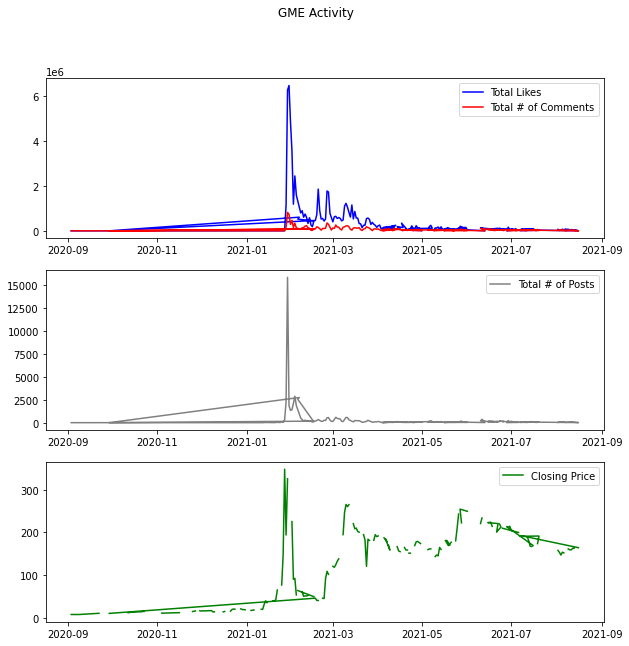

In [604]:
from datetime import datetime
temp_gme = clean_gme.join(gme_df.set_index('Date'), on='Date')
date = datetime.strptime('2020-09-01', '%Y-%m-%d').date()
temp_gme = temp_gme.loc[temp_gme['Date'] >= date]
temp_gme = temp_gme.set_index('Date')

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,10))
fig.suptitle('GME Activity')
ax1.plot(temp_gme['sum_score'], color='blue', label='Total Likes')
ax1.plot(temp_gme['sum_comms_num'], color='red', label='Total # of Comments')
ax2.plot(temp_gme['num_posts'], color='gray', label='Total # of Posts')
ax3.plot(temp_gme['Close'], color='green', label='Closing Price')

ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

As expected, there is a simultaneous spike in all three of the WSB likes/comments on posts about GME, WSB posts with GME/GameStop in the title, and the GME closing price. 

One might be able to find informative behavior from WSB during this time range of spiked activity to build more possible features, which we started. A concern, however, is that in comparison the GME activity outside that date range is fairly stagnant, which might pose a problem that we will discuss further down, especially when it comes to having fewer universally "rich" features.

## Heatmap of Correlations

Heatmap of correlations between numeric columns

In [605]:
agg_gme_corr = agg_gme.corr()
agg_gme_corr.head(10)

sum_score  ...  overall_sentiment_maxcomments
sum_score          1.000000  ...                       0.158072
sum_comms_num      0.910363  ...                       0.079541
avg_title_length  -0.020541  ...                      -0.020169
like_count         0.755528  ...                       0.059650
buy_count          0.640817  ...                       0.023438
bought_count       0.672875  ...                       0.055253
sell_count         0.669306  ...                       0.034990
hold_count         0.660010  ...                       0.042966
new_count          0.721759  ...                       0.042777
rocket_count       0.717312  ...                       0.051304

[10 rows x 23 columns]

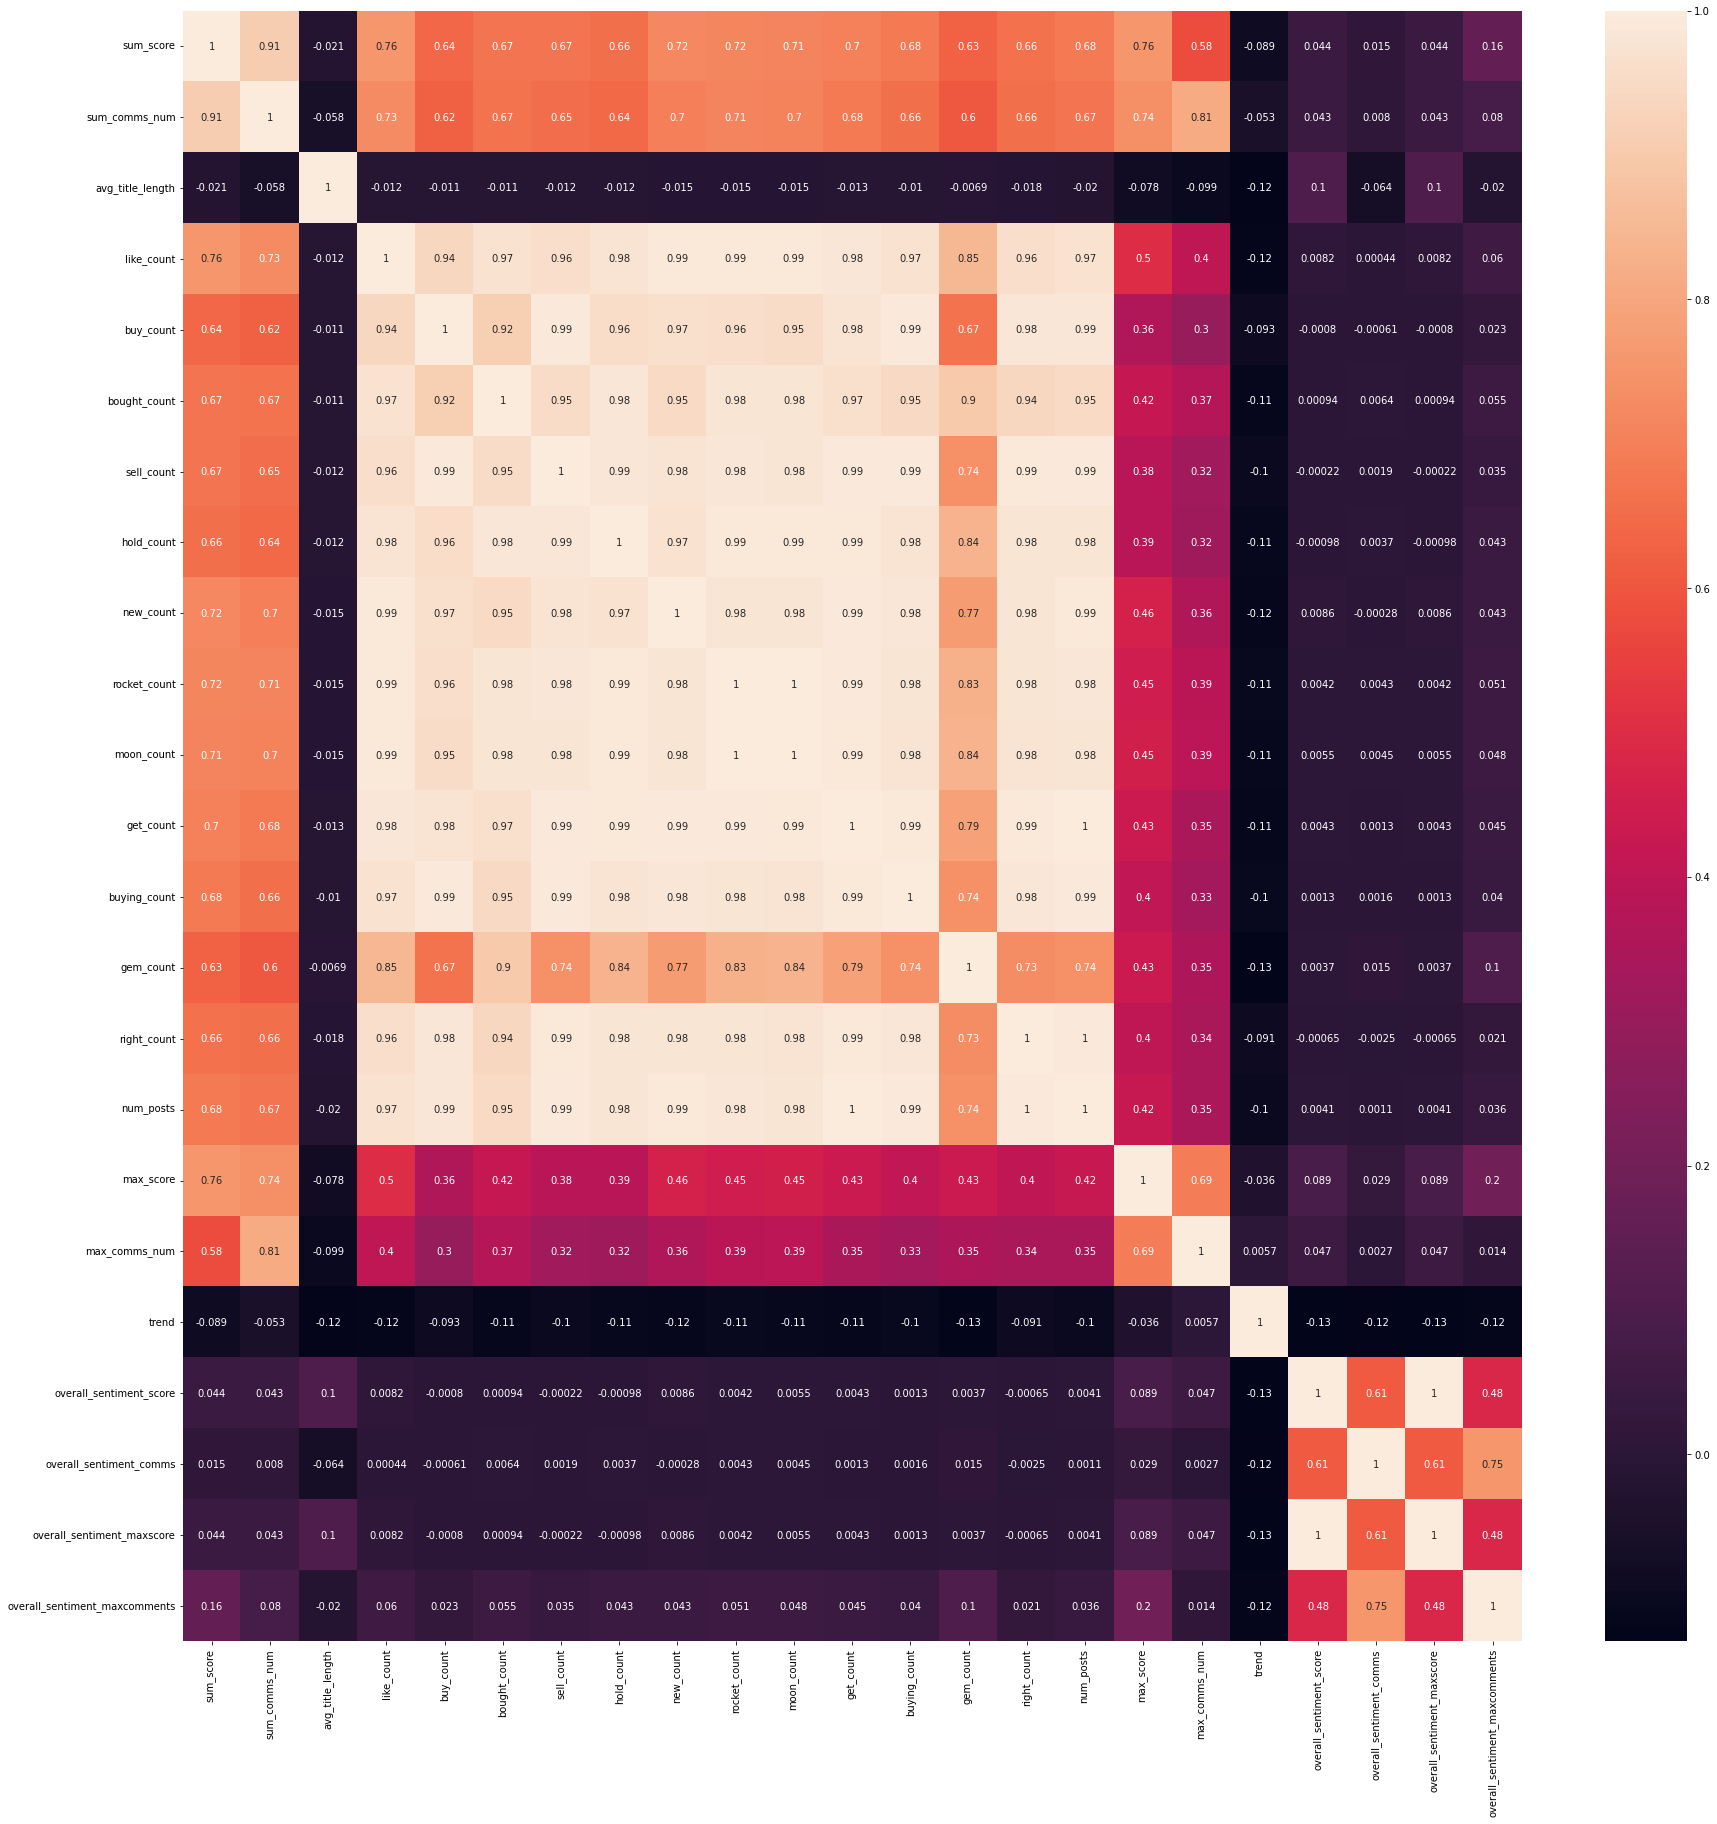

In [606]:
plt.figure(figsize=(30,30))
ax = sns.heatmap(agg_gme_corr, annot=True)

As expected, much of our keyword counts columns are highly correlated with one another and the number of posts column. Naturally, as there are more posts in a given day, we expect to see more appearances of these keywords. Likewise, there is a high correlation between many of our weighted sentiment scores. It appears that simply weighting the sentiment scores differently did not actually change the sum of scores across each day.

These high correlations among factors will be addressed when we perform PCA to reduce the dimensionality before plugging the data into our models.

#Part 8: Machine Learning 

For our Machine Learning portion of the project we chose to do (in order below)

1.  a Random Forest Classifier
2.  a SVC (support vector classifier)
3.  a NN (using PyTorch)

Given that we had decently large data and no real need for interpretability, a Random Forest Model made a lot of sense. Additionally, since our data was  multiclass (-1, 0, or 1), this was another reason to choose a Random Forest.

From here, we also decided to use a Support Vector Machine, specifically a classifier, given its effectiveness in high dimension spaces. Being able to either use a polynomial or Gaussian RBF kernel would make our model accurate in classifying even data that is not lineraly separable.

Finally, given that this is a relatively complex machine learning problem, we thought it'd always be good to include a neural net to capture/identiy any hidden relationships in our data.

We perform Standard Scaler and PCA before conducting Supervising Learning.

Import the necessary packages from sklearn:

In [607]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

Now let's split our data into training and test data, where 70% is training data and 30% is test data.

Our features will include:
- Total # of upvotes (score)
- Total # of comments 
- Average Title Length
- Number of Titles with specific words (e.g., 'like', 'buy', 'moon', etc.)
- Overall Sentiment weighted by different 'relevancy' metrics

Our label will be:
- stock trend (5 market day period)

In [608]:
features = agg_gme[['sum_score', 'sum_comms_num', 'avg_title_length', 'like_count', \
                    'buy_count', 'bought_count', 'sell_count', 'hold_count', 'new_count',\
                    'rocket_count', 'moon_count', 'get_count', 'buying_count', 'gem_count',\
                    'right_count', 'num_posts', 'max_score', 'max_comms_num',\
                    'overall_sentiment_score', 'overall_sentiment_comms',\
                    'overall_sentiment_maxscore', 'overall_sentiment_maxcomments']]
labels = agg_gme[['trend']]
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=42)

First, lets take a look at the RandomForestClassifier

## Random Forest Classifier

In [609]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [610]:
agg_gme.columns

Index(['Date', 'sum_score', 'sum_comms_num', 'avg_title_length', 'like_count',
       'buy_count', 'bought_count', 'sell_count', 'hold_count', 'new_count',
       'rocket_count', 'moon_count', 'get_count', 'buying_count', 'gem_count',
       'right_count', 'num_posts', 'max_score', 'max_comms_num', 'trend',
       'overall_sentiment_score', 'overall_sentiment_comms',
       'overall_sentiment_maxscore', 'overall_sentiment_maxcomments'],
      dtype='object')

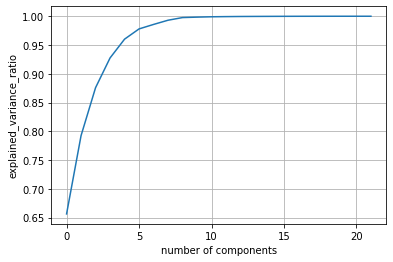

In [611]:
X_train = pd.DataFrame(X_train)

scl = StandardScaler()
X_train_standard = scl.fit_transform(X_train)
X_test_standard = scl.transform(X_test)

pca_trial = PCA()
X_train_pca = pca_trial.fit_transform(X_train_standard)

explained_variance = pca_trial.explained_variance_ratio_
explained = np.cumsum(explained_variance)
plt.clf()
plt.plot(explained)
plt.grid()
plt.xlabel('number of components')
plt.ylabel('explained_variance_ratio')
plt.show()

From this plot, it seems that the 'elbow' is at 7; we should project using 7 n_components!

In [612]:
pca = PCA(n_components=7)
X_train = pca.fit_transform(X_train_standard)
X_test = pca.transform(X_test_standard)

def print_best_params(y):
  print('best_params: {}\n'.format(y.best_params_))

model = RandomForestRegressor()
param_grid = {
    'max_depth': [5, 10, 20, 30],
    'n_estimators': [10, 30, 64, 100]
}

gsc = GridSearchCV(estimator=model, param_grid=param_grid)

rfc_cv = gsc.fit(X_train, y_train.values.ravel())
best_params = rfc_cv.best_params_

rfc = RandomForestClassifier(max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'])

In [613]:
print_best_params(rfc_cv)

best_params: {'max_depth': 5, 'n_estimators': 100}



We have found that the optimal parameters are a max depth of 5, and 10 estimators. We now use these on our data:

In [614]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [615]:
pipe = Pipeline(steps=[('Scale', scl), ('PCA', pca), ('RandomForestRegression', rfc)])

pipe.fit(X_train, y_train.values.ravel())
prediction = pipe.predict(X_test)

In [616]:
print('Accuracy: ', accuracy_score(y_test, prediction))

Accuracy:  0.5157894736842106


A 51.57% is certainly not very impressive, but still a start 😆. Next, lets take a look the SVC!

##Support Vector Classification (SVC)

Again using the sklearn library, we initialize and fit our model first using a RBF kernel.


In [617]:
from sklearn.svm import SVC
classifier = SVC(kernel='rbf', random_state = 1)
classifier.fit(X_train, y_train)

Y_pred = classifier.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix

In [618]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, Y_pred)
accuracy = float(cm.diagonal().sum())/len(y_test)
print("\nAccuracy Of SVM For The Given Dataset : ", accuracy)


Accuracy Of SVM For The Given Dataset :  0.6


Using a RBF kernel, we get an accuracy of 60% - this is already an improvement from the Random Forest!

Labels

In [619]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y_train = le.fit_transform(y_train.values.ravel())

Time to tune now with GridSearch again!

In [620]:
param_grid = {'C': [0.1,1, 10, 100], 
              'gamma': [1,0.1,0.01,0.001],
              'kernel': ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
cv_1 = grid.fit(X_train, y_train.values.ravel())

best_params_1 = cv_1.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, k

In [621]:
best_params_1

{'C': 10, 'gamma': 0.1, 'kernel': 'poly'}

Our best parameters are C = 10 (a cost for misclassifying) and a polynomial kernel with gamma = 0.1.

Fit to SVM and use our pipeline!

In [622]:
classifier = SVC(C= best_params_1['C'], kernel=best_params_1['kernel'], gamma=best_params_1['gamma'], random_state = 1)

In [623]:
pipe1 = Pipeline(steps=[('Scale', scl), ('PCA', pca), ('svc', classifier)])

pipe1.fit(X_train, y_train.values.ravel())
prediction_SVC = pipe1.predict(X_test)

Now let's check our accuracy and hope it's better than the random forest classifier! 🤞

In [624]:
print('Accuracy_SVC: ', accuracy_score(y_test, prediction_SVC))

Accuracy_SVC:  0.5894736842105263


Our accuracy here is 58.95%, less than the 60% we got using a RBF kernel. This likely means that our data is not as easily linearly separable; this also a better accuracy than using the random forest.

___


##Neural Network

Initial things to do:
- Let's first scale by the MinMinScaler
- 70% of the data will be used for training, 30% of the data will be used for testing.
- Then convert from numpy array to tensors

In [650]:
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=42)

scl = MinMaxScaler()
X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)

X_train, y_train = torch.from_numpy(np.array(X_train)).float(), torch.from_numpy(np.array(y_train)).long()
X_test, y_test = torch.from_numpy(np.array(X_test)).float(), torch.from_numpy(np.array(y_test)).long()

Make sure to import the necessary libraries or this model won't be able to run! 😀

In [651]:
import torch
import torch.nn as nn

In [652]:
EPOCHS = 400 # use 400 epochs
NUM_FEATURES = len(features.columns)
NUM_CLASSES = 3 # number of output classes

The neural network structure we created includes:
- linear layers
- relu layers
- dropouts
- batch normalization (make sure to use before the non-linear layers)


In [653]:
class Neural_Network(nn.Module):
    def __init__(self, features, num_class):
        super(Neural_Network, self).__init__()
        
        self.layer_1 = nn.Linear(features, 256)
        self.layer_2 = nn.Linear(256, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [654]:
model = Neural_Network(features = NUM_FEATURES, num_class=NUM_CLASSES)

criterion = nn.CrossEntropyLoss() # loss function
loss_list = []
accuracy_list = []
print(model)

Neural_Network(
  (layer_1): Linear(in_features=22, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Our defined function to calculate our predictions accuracy: we take the index with the highest probability and check if it matches the corresponding test value between 0 and 2.

In [655]:
def multi_accuracy(y_pred, y_test):
    y_pred_cats = torch.argmax(y_pred, dim = 1)    
    
    correct_pred = (y_pred_cats == y_test).float()
    print
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    return acc

Now let's test our various learning rates. We increment the target values by 1 because the Cross Entropy Loss considers values >= 0.

In [656]:
learning_rate = [0.001, 0.01, 0.05, 0.1, 0.3]
y_train = y_train + 1
y_train = torch.squeeze(y_train) # to ensure proper dimensions when feeding it into our criterion

Now let's run our neural network model:

In [657]:
# test on various learning rates
for l in learning_rate:
  optimizer = torch.optim.Adam(model.parameters(), lr=l)
  for e in range(1, EPOCHS+1):
    model.train()
    optimizer.zero_grad()
    
    y_train_predicted = model(X_train)
    
    train_loss = criterion(y_train_predicted, y_train)
    train_accuracy = multi_accuracy(y_train_predicted, y_train)

    train_loss.backward()
    optimizer.step()
            
    if (e == EPOCHS):
      last_loss = train_loss
      final_acc = train_accuracy
      loss_list.append(train_loss)
      accuracy_list.append(train_accuracy)
      print("Using learning rate {} during last epoch, loss: {} & accuracy taking max prob: {}".format(l, last_loss, final_acc))
                              

Using learning rate 0.001 during last epoch, loss: 0.16182191669940948 & accuracy taking max prob: 90.0
Using learning rate 0.01 during last epoch, loss: 0.16438233852386475 & accuracy taking max prob: 90.0
Using learning rate 0.05 during last epoch, loss: 0.20600873231887817 & accuracy taking max prob: 89.0
Using learning rate 0.1 during last epoch, loss: 0.23937776684761047 & accuracy taking max prob: 87.0
Using learning rate 0.3 during last epoch, loss: 0.5834521055221558 & accuracy taking max prob: 64.0


From here, it's clear that the best learning rate to use is 0.001, with an accuracy score of 90% (!) when taking the index corresponding to the maximum of the probabilities as our "prediction".

The following function is another way to record the accuracy of the model. However, instead of simply taking the absolute maximum of the probabilities and checking if it corresponds to the correct target value, this function applies softmax.

In [658]:
def multi_acc_softmax(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    return acc

#**Challenges and Responses**

From the start, our biggest challenge that our group faced was gaining enough meaningful data for Machine Learning to be accurate. Our initial dataset performed very poorly, with an accuracy of ~50% on the RandomForestClassifer and the SVC.

There were a couple of things that we chose to do and explore:
- Add new possibly informative columns by encoding titles that contained certain words. This was also partly inspired by the limitations of Afinn as a sentiment analysis.
- Looked at other stocks to see if they produced similar results. 
- We found an additional dataset that provided us with a wider date range to work with, which helped improve the performance of the ML slightly (from 48% to 60% on the SVC, with almost no change in improvement on the RandomForestClassifer). 



# **Model Comparison**
In the end, the data and features were not rich enough to produce meaningful results from our models. From a complete numbers comparison, both the RandomForestClassifier and SVC performed worse than the Neural Network. The Neural Network seems more promising with significantly higher accuracies for the predictions, rather than the ~50% to 60% accuracy the other 2 models produced.

While these models seem to be useless given their accuracies, we think it is less likely that the actual implementations and choices of models is what is wrong but more the lack of informative features and lack of data, both of which can be potentially solved given more time and research.

### So why did we choose these models?
All 3 of these models are frequently used as classifier models. They have proven useful to predict and classify various other problems. In addition to our tuning, these models go beyond a simple logistic regression model. For example, a random forest classifier is a meta estimator that fits a number of decision tree classifiers. We also took inspiration from current research being done that suggested similar models. 

# **For Future Study**

  In the future, we could consider using VADER, BERT, or any other sentiment analysis tool that is more updated and accurate on text akin to Reddit posts. We could also look more into Reddit-specific metrics, like flairs, or mentions of phrases like 'YOLO' or 'to the moon'. Finally, our field of study could be broadened to other investing-centric subreddits, or perhaps even Reddit as a whole, as the entire platform was very active (including skeptics of this movement).